In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# download the dataset
cdata = torchvision.datasets.CIFAR10( root = 'cifar10', download = True  )

Files already downloaded and verified


In [ ]:
# inspect the data

# the categories 
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

numimages = cdata.data.shape[0]
print(numimages)

# # transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.reshape((numimages,3,32,32))
images = torch.tensor(images.astype(float))
print('\nTensor data:')
print(images.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10 classes

Data size:
(50000, 32, 32, 3)
50000

Tensor data:
torch.Size([50000, 3, 32, 32])


In [ ]:
labels = torch.tensor(copy.deepcopy(cdata.targets))
torch.unique(labels)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

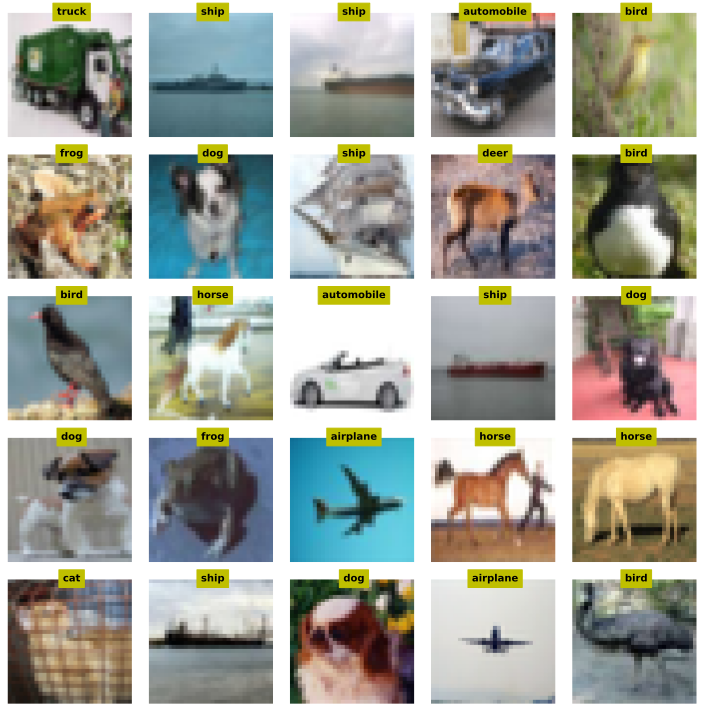

In [ ]:
# inspect a few random images

fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

  # select a random picture
  randidx = np.random.choice(len(cdata.targets))

  # extract that image
  pic = cdata.data[randidx,:,:,:]
  # and its label
  label = cdata.classes[cdata.targets[randidx]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

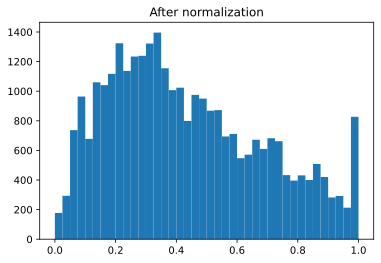

In [ ]:
# # next issue: do we need to normalize the images?
# plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
# plt.title('Raw values')
# plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# specify sizes of the partitions
# order is train,devset,test
partitions = [.8,.1,.1]

# split the data (note the third input, and the TMP in the variable name)
train_data,testTMP_data, train_labels,testTMP_labels = \
                   train_test_split(images, labels, train_size=partitions[0])

# now split the TMP data
split = partitions[1] / np.sum(partitions[1:])
devset_data,test_data, devset_labels,test_labels = \
              train_test_split(testTMP_data, testTMP_labels, train_size=split)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
devset_data = TensorDataset(devset_data,devset_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
devset_loader  = DataLoader(devset_data,  batch_size=batchsize)

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifar10(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d( 3,12,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(12) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(12,48,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(48) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(48,192,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(192) # input the number of channels in this layer
      # output size: (8+2*1-3)/1 + 1 = 8/2 = 4 (/2 b/c maxpool)



      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(4*4*192,200)
      self.fc2 = nn.Linear(200,100)
      self.fc3 = nn.Linear(100,50)
      self.fc4 = nn.Linear(50,10)

    def forward(self,x):
      x = x.float()
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d( self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout( x,p=0.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout( x,p=0.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout( x,p=0.1,training=self.training)
      if self.print: print(f'Third CPR block: {list(x.shape)}')


      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout( x,p=0.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout( x,p=0.5,training=self.training)
      x = F.leaky_relu(self.fc3(x))
      x = self.fc4(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cifar10(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First CPR block: [32, 12, 16, 16]
Second CPR block: [32, 48, 8, 8]
Third CPR block: [32, 192, 4, 4]
Vectorized: [32, 3072]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3107, grad_fn=<NllLossBackward0>)


In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  
  devsetLoss = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  
  devsetErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(devset_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    devsetErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,devsetLoss,trainErr,devsetErr,net

In [ ]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,devsetLoss,trainErr,devsetErr,net = function2trainTheModel()

In [ ]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

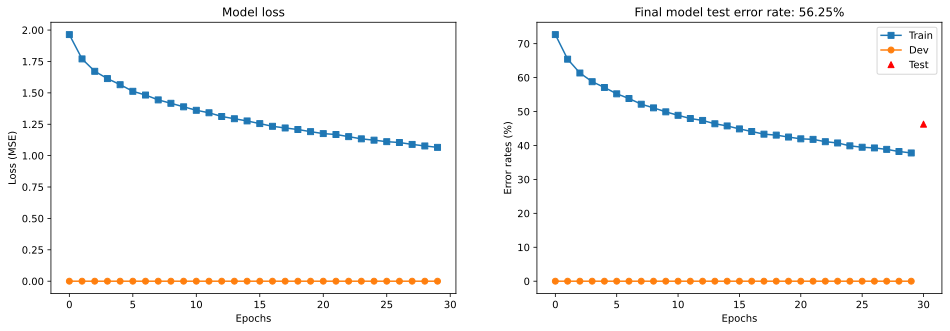

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devsetLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(devsetErr,'o-',label='Dev')
ax[1].plot(30,testAcc,'r^',label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()